In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import path
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns


import os
print(os.listdir("../input"))

# read data in pandas dataframe
# df_train =  pd.read_csv('../input/train.csv', nrows = 150000, parse_dates=["pickup_datetime"])
df_train =  pd.read_csv('../input/train.csv', nrows = 5000, parse_dates=["pickup_datetime"])
'''
print(len(df_train))
print(df_train.dtypes)
'''
df_train.head()

['GCP-Coupons-Instructions.rtf', 'train.csv', 'sample_submission.csv', 'test.csv']
5000
key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


**Data Cleaning**

In [3]:
# check and drop the missing values
print(df_train.isnull().sum())
df_train = df_train.dropna(how = 'any', axis = 'rows')

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


count    5000.000000
mean       11.296238
std         9.710106
min        -2.900000
25%         6.000000
50%         8.500000
75%        12.500000
max       180.000000
Name: fare_amount, dtype: float64


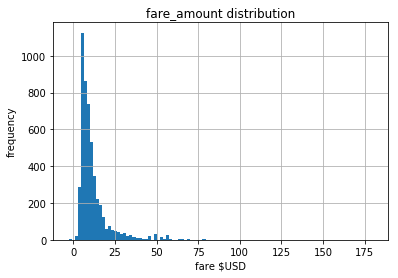

In [4]:
# check for outliers in fare_amount 
df_train["fare_amount"].hist(bins=100)
plt.xlabel('fare $USD')
plt.ylabel('frequency')
plt.title('fare_amount distribution')
'''
print(df_train["fare_amount"].describe())
'''
# the minimal fare_amount is negative, which is not realistic, so drop them
df_train = df_train[df_train.fare_amount>=0]

count    4998.000000
mean        1.631253
std         1.257310
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: passenger_count, dtype: float64


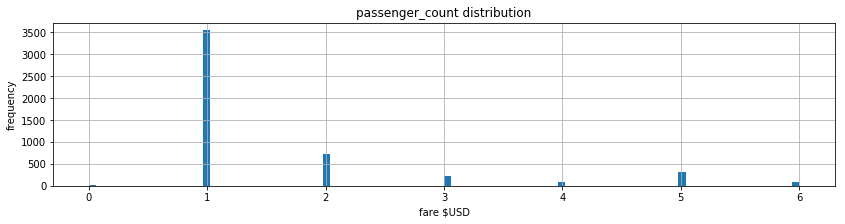

In [5]:
# check for outliers in passenger_count 
df_train["passenger_count"].hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.ylabel('frequency')
plt.title('passenger_count distribution')
'''
print(df_train["passenger_count"].describe())
'''
# passenger_count of zero or larger than 6 (a SUV cab) seems to be not realistic, so drop them
df_train = df_train[(df_train['passenger_count']>0) & (df_train['passenger_count']<=6)]

In [6]:
# Googling latitudes and longitudes give such information
# Latitudes range from -90 to 90.
# Longitudes range from -180 to 180.
'''
print(df_train['pickup_latitude'].describe())
print(df_train['pickup_longitude'].describe())
print(df_train['dropoff_latitude'].describe())
print(df_train['dropoff_longitude'].describe())
'''

# it shows some data errors in latitude and longitude,
# including outliers and wrong order when inserted latitude and longitude into dataset
# by using Google map, the latitude and longitude coordinate of New York City is:
nyc = (40.730610, -73.935242)

# so drop trips that are out of New York City and its nearby areas
def city_nearby_areas(df, city):
    return (df['pickup_longitude'] >= city[1]-1.5) & (df['pickup_longitude'] <= city[1]+1.5) & \
           (df['pickup_latitude'] >= city[0]-1.5) & (df['pickup_latitude'] <= city[0]+1.5) & \
           (df['dropoff_longitude'] >= city[1]-1.5) & (df['dropoff_longitude'] <= city[1]+1.5) & \
           (df['dropoff_latitude'] >= city[0]-1.5) & (df['dropoff_latitude'] <= city[0]+1.5)

df_train = df_train[city_nearby_areas(df_train, nyc)]
print(len(df_train))

count    4982.000000
mean       39.864078
std         6.362589
min       -73.991840
25%        40.734036
50%        40.752169
75%        40.766895
max        41.366138
Name: pickup_latitude, dtype: float64
count    4982.000000
mean      -72.421293
std        10.741341
min       -74.438233
25%       -73.992465
50%       -73.982081
75%       -73.967047
max        40.751582
Name: pickup_longitude, dtype: float64
count    4982.000000
mean       39.872625
std         6.337287
min       -73.979010
25%        40.734401
50%        40.753512
75%        40.767617
max        41.032598
Name: dropoff_latitude, dtype: float64
count    4982.000000
mean      -72.420618
std        10.741255
min       -74.429332
25%       -73.991346
50%       -73.980196
75%       -73.963616
max        40.758867
Name: dropoff_longitude, dtype: float64
4876


In [7]:
# a function to calculate distance between two latitude longitude points.
# this function is based on https://stackoverflow.com/questions/27928/
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

# calculate the distance in kilometers between pickup and dropoff postion of each trip 
df_train['distance_km'] = df_train.apply(lambda x: distance(x["pickup_latitude"], x["pickup_longitude"], \
                                   x["dropoff_latitude"], x["dropoff_longitude"]), axis=1)

In [ ]:
# check for outliers in distance_km 
print(df_train["distance_km"].describe())

plt.scatter(df_train["distance_km"], df_train["fare_amount"], alpha=0.2)
plt.xlabel('distance in kilometers')
plt.ylabel('fare $USD')
plt.title('distance vs. fare')

# the plot shows there are trips with zero distance but with a non-zero fare
# drop trips with zero distance
df_train = df_train[df_train["distance_km"] >= 0.1]
print(len(df_train))

# the plot also shows some long trips but with low fare, just leave them now and I will analyze them later
# df_train[df_train.fare_amount > 50]

In [ ]:
plt.scatter(df_train["pickup_longitude"], df_train["pickup_latitude"], alpha=0.2)
plt.xlim(nyc[1]-0.1, nyc[1])
plt.ylim(nyc[0]-0.05, nyc[0]+0.05)
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')
plt.title('pickup positions')

# df_train = df_train[(df_train["distance_km"] < 80)]

In [ ]:
'''
contains_point(point, transform=None, radius=0.0):
    Returns whether the (closed) path contains the given point.
cw_path  = path.Path([[0,0], [0,1], [1,2], [3,2], [2,1], [3,0]])
cw_path.contains_point([1.5, 1])
'''

**Check If a Taxi Trip is To/From Airport**

Taxi trip between JFK and Manhattan is a flat fare.

Taxi trip to EWR has a Newark Surcharge

In [12]:
# check if a give place (coordinate) is loacted in the specified area
def in_area(area, place):
    p = path.Path(area)
    res = p.contains_point(place)
    return res
# in_area(Manhattan, [40.745969, -74.027072])

In [13]:
# Manhattan area boundary is defined by following coordinates
Manhattan = [(40.686909, -74.034496), (40.680376, -74.021145), (40.704307, -73.997131), (40.709044, -73.974796), \
               (40.745379, -73.962538), (40.771583, -73.938199), (40.773910, -73.939632), (40.780453, -73.935530), \
               (40.780316, -73.924544), (40.795204, -73.910464), (40.802289, -73.927286), (40.810788, -73.933235), \
               (40.835167, -73.934011), (40.873370, -73.906769), (40.879385, -73.910359), (40.875912, -73.915514), \
               (40.882451, -73.934690), (40.755360, -74.014918)]

In [ ]:
# Airport trip to/from JFK and any location in Manhattan is a flat fare
# Airport trip from JFK to other New York City destinations is a metered fare
# Airport trip to Newark Liberty International Airport is a metered fare with a Newark Surcharge
# Airport trip to LaGuardia Airport is a metered fare

# check if the trip is between JFK and a location in Manhattan, or the trip dropoff at to Newark Airport,
# dropoff/pickup at the place where is less than 2 km from airport is regarded as trip to/from airport
jfk = (40.6413, -73.7781)
ewr = (40.6895, -74.1745)

def airport_trip(trip):
    if distance(trip["dropoff_latitude"], trip["dropoff_longitude"], jfk[0], jfk[1]) <= 2 and \
    in_area(Manhattan, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        return "jfk_Manhattan"
    elif distance(trip["pickup_latitude"], trip["pickup_longitude"], jfk[0], jfk[1]) <= 2 and \
    in_area(Manhattan, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True:
        return "jfk_Manhattan"
    elif distance(trip["dropoff_latitude"], trip["dropoff_longitude"], ewr[0], ewr[1]) <=2:
        return "airport_ewr"
    else:
        return "not_airport"

df_train["to_airport"] = df_train.apply(lambda row: airport_trip(row), axis=1)


In [ ]:
# using one-hot encoding to transform to_airport feature for fitting regression model 
df_airport = pd.get_dummies(df_train["to_airport"])
df_train = df_train.join(df_airport)

**Extract Hour and Day From pickup_datetime**

Taxi trip at night has extra surcharge.

The amount of traffic also depends on the hour of the day, and it determines the duration of the trip and thus the fare. 

In [ ]:
def hour_type(hour, weekday):
    if hour in list(range(20, 25)) + list(range(0,7)):
        return "night"
    elif hour in range(7, 10) and weekday == 1:
        return "morning_peak"
    elif hour in range(16, 20) and weekday == 1:
        return "afternoon_peak"
    else:
        return "normal_hour"

def extract_time(record):
    record['hour'] = record["pickup_datetime"].hour
    record['year'] = record["pickup_datetime"].year
    record["day_of_week"] = record["pickup_datetime"].weekday()
    record["weekday"] = 1 if record["day_of_week"] in range(0, 5) else 0
    record["hour_type"] = hour_type(record["hour"], record["weekday"])
    return record

df_train = df_train.apply(lambda r: extract_time(r), axis=1)

df_hour_type = pd.get_dummies(df_train["hour_type"])
df_train = df_train.join(df_hour_type)

# Another method to find the day of week 
# day_of_week = pd.to_datetime(df_train["pickup_datetime"]).dt.weekday_name
# or
# day_of_week = pd.to_datetime(df_train["pickup_datetime"]).dt.dayofweek

# df_train['hour'] = df_train["pickup_datetime"].apply(lambda t: t.hour)
# df_train['year'] = df_train["pickup_datetime"].apply(lambda t: t.year-2009)
# df_train["day_of_week"] = df_train["pickup_datetime"].apply(lambda t: t.weekday())

**Check If a Taxi Trip is Group Ride**

Two, three, or four people can take a group ride from a yellow taxi Group Ride Stand and pay a flat rate.

Group Ride pickup times are certain hours, Monday – Friday (excluding holidays).

In [ ]:
# GR_1:
# York Ave / 70th St, Frankfort St / Pearl St & on to World Financial Center, 
# $6.00, 6AM – 10AM

# GR_2:
# Port Authority Bus Terminal, 59th St / 6th Ave, 
# $3.00, 6AM– 10AM

# GR_3:
# LaGuardia Airport - Marine Air Terminal, Bet 35th & 59th St & Bet 2nd Ave & 8th Ave,
# $22/person with 2 passengers, $18/person with 3 passengers, 7AM – 10AM & 4PM – 8PM

# GR_4:
# 57th St / 8th Ave, 57th St to Park Ave / 42nd St,
# $3.00, 6AM– 10AM

# GR_5:
# 72nd St / 3rd Ave, Park Ave / 42nd St,
# $4.00, 6AM– 10AM

# GR_6:
# 72nd St / Columbus Ave, Park Ave / 42nd St,
# $4.00, 6AM– 10AM


**Check If Trips Crossed Boroughs, Which may Caused Toll Fees to Fare Amount**

Passengers must pay tolls if the trip between New Jersey/Manhattan, Manhattan/Queens+Brooklyn,  Staten Island/Brooklyn and New Jersey/Staten Island

In [9]:
# New Jersey boundary coordinates:
New_Jersey = [(40.998125, -73.892134), (40.752798, -74.011413), (40.652655, -74.046638), (40.643193, -74.152969), \
              (40.647175, -74.181208), (40.631922, -74.203180), (40.557508, -74.219282), (40.549155, -74.247418), \
              (40.521271, -74.246102), (40.509769, -74.258537), (40.475795, -74.237970), (40.484005, -73.955930), \
              (38.760545, -74.169389), (39.065187, -75.640440), (41.927266, -75.595312)]

# Brooklyn and Queens bounday coordinates
Brooklyn_Queens = [(40.686909, -74.034496), (40.680376, -74.021145), (40.704307, -73.997131), (40.709044, -73.974796), \
                   (40.745379, -73.962538), (40.771583, -73.938199), (40.773910, -73.939632), (40.780453, -73.935530), \
                   (40.780316, -73.924544), (40.795204, -73.910464), (40.809220, -73.776494), (40.752348, -73.700726), \
                   (40.545962, -73.741831), (40.531383, -74.053978)]

# Staten Island boundary coordinates:
Staten_Island = [(40.652655, -74.046638), (40.643193, -74.152969), (40.647175, -74.181208), (40.631922, -74.203180), \
                 (40.557508, -74.219282), (40.549155, -74.247418), (40.521271, -74.246102), (40.509769, -74.258537), \
                 (40.475795, -74.237970), (40.484005, -73.955930)]

In [14]:
def tolls_fees(trip):
    # trip pickup at New Jersey
    if in_area(New_Jersey, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Manhattan, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_NJ_Manh"] = 1
    elif in_area(New_Jersey, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Brooklyn_Queens, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_NJ_Manh"] = 1
        trip["tolls_Manh_BQ"] = 1
    elif in_area(New_Jersey, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Staten_Island, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_NJ_SI"] = 1
    
    # trip pickup at Manhattan
    elif in_area(Manhattan, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Brooklyn_Queens, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_Manh_BQ"] = 1
    elif in_area(Manhattan, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Staten_Island, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_BQ_SI"] = 1
    # no tolls fee from Manhattan to New Jersey
    
    # trip pickup at Brooklyn or Queens
    elif in_area(Brooklyn_Queens, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(New_Jersey, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_Manh_BQ"] = 1
    elif in_area(Brooklyn_Queens, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Manhattan, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_Manh_BQ"] = 1
    elif in_area(Brooklyn_Queens, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Staten_Island, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_BQ_SI"] = 1
    
    # trip pickup at Staten Island
    elif in_area(Staten_Island, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Manhattan, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_Manh_BQ"] = 1
    # no tolls fee from Staten Island to New Jersey, Brooklyn and Queens
    
    return trip

# there are 4 levels of toll fees between boroughs of New York
# single way
df_train["tolls_NJ_Manh"] = 0
df_train["tolls_BQ_SI"] = 0
df_train["tolls_NJ_SI"] = 0
# each way
df_train["tolls_Manh_BQ"] = 0

df_train = df_train.apply(lambda row: tolls_fees(row), axis=1)

In [18]:
df_train[df_train["tolls_Manh_BQ"]==1][["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]].head(10)

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
28,40.690835,-73.989258,40.725690,-74.004133
31,40.717667,-74.010483,40.660366,-73.985771
32,40.773883,-73.873027,40.769545,-73.984545
34,40.740785,-73.993717,40.676617,-73.999272
56,40.758853,-73.985427,40.774497,-73.872907
86,40.746485,-73.917399,40.763836,-73.973756
112,40.787772,-73.953310,40.719772,-73.944352
118,40.774105,-73.872862,40.764393,-73.970593
126,40.729325,-73.987210,40.697207,-73.931985
131,40.676052,-73.983837,40.723145,-74.002522


In [ ]:
df_train = df_train[df_train.fare_amount>=0]
df_train.head(8)

In [ ]:
# for year in list(df_train["year"].unique()):
#     temp_df = df_train[(df_train["airport"] == "not_airport") & (df_train["year"] == year)]
#     sns.lmplot(x="distance_km", y="fare_amount_no_surage", data=temp_df, fit_reg=True)
#     plt.title("simple regression for year = " + str(year))


In [ ]:
# a test to research the effect of feature "year" on fare to airport
airport_fare_byYear = pd.DataFrame(df_train.groupby(['airport', 'year'])['fare_amount'].mean())
airport_fare_byYear.reset_index(inplace=True)  
airport_fare_byYear

**Model**

linear regression model: 
    
    fare_amount ~ distance_km + passenger_count + year + weekday + afternoon_peak + morning_peak + night + normal_hour

In [ ]:
# X = df_train.drop('fare_amount_no_surage', axis=1)
# y = df_train['fare_amount_no_surage']

df_train_no_airport = df_train[df_train["airport"] == "not_airport"]
features = ["distance_km", "passenger_count", "weekday", "afternoon_peak", "morning_peak", "night", "normal_hour"]
year_coef_dic = {}

for year in list(df_train["year"].unique()):
    temp_df = df_train_no_airport[df_train_no_airport["year"] == year]
    temp_lm = LinearRegression()
    temp_lm.fit(temp_df[features], temp_df["fare_amount_no_surage"])
    year_coef_dic[year] = [temp_lm.intercept_] + list(temp_lm.coef_)
    
year_coef_dic

# X = df_train_no_airport.drop('fare_amount_no_surage', axis=1)
# y = df_train_no_airport['fare_amount_no_surage']

# X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.25)
# X.shape, y.shape


In [ ]:
def adjust_fare(record, prediction):
    if record["night"] == 1:
        prediction = prediction + 0.5
    if record["weekday"] == 1 and record["afternoon_peak"] == 1:
        prediction = prediction + 1
    
    if record["airport"] == "airport_jfk":
        prediction = jfk_fare
    elif record["airport"] == "airport_ewr":
        prediction = ewr_fare
    elif record["airport"] == "airport_lgr":
        prediction = lgr_fare
    
    return prediction


In [ ]:
def calculate_pred(row):
    input_value = [1] + row[features].values.tolist()
    coef = year_coef_dic[row["year"]]
    y_pred = sum([a*b for a,b in zip(input_value,coef)]).round(decimals = 2)
    y_adjust_pred = adjust_fare(row, y_pred)
    return y_adjust_pred

df_train["prediction"] = df_train.apply(lambda row: calculate_pred(row), axis=1)
df_train.head(5)

In [ ]:
def plot_prediction_analysis(y, y_pred):    
    plt.scatter(y, y_pred)
    plt.xlabel("real y")
    plt.ylabel("predicted y")
    plt.plot([0, max(df_train["fare_amount"])], [0, max(df_train["fare_amount"])], color='red', linestyle='-', linewidth=0.5)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    plt.title('rmse = {:.2f}, with zero residual diagonal line'.format(rmse))
    plt.show()


In [ ]:
# prediction plot for training dataset
plot_prediction_analysis(df_train["fare_amount"], df_train["prediction"])

# df_predict_y.index = df_train.index
# df_train_predict = pd.concat([df_train, df_predict_y], axis=1)
# adjust_predict_y = df_train_predict.apply(lambda r: adjust_fare(r), axis=1)
# # adjust_predict_y.head()
# plot_prediction_analysis(df_train["fare_amount"], adjust_predict_y)

**Validation Dataset Experiment**

In [ ]:
df_validation =  pd.read_csv('../input/train.csv', skiprows = 200000, nrows = 50000, \
                             names = ["key","fare_amount","pickup_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count"], \
                             parse_dates=["pickup_datetime"])
print(len(df_validation))
print(df_validation.dtypes)
print(df_validation.isnull().sum())
df_validation.head()

In [ ]:
# preprocessing dataset to extract features
def preprocess_dataset(df):
    df['distance_km'] = df.apply(lambda x: distance(x["pickup_latitude"], x["pickup_longitude"], \
                                   x["dropoff_latitude"], x["dropoff_longitude"]), axis=1)
    df["airport"] = df.apply(lambda x: to_airport(x["dropoff_latitude"], x["dropoff_longitude"]), axis=1)
    df = df.apply(lambda r: extract_time(r), axis=1)
    df_hour_type = pd.get_dummies(df["hour_type"])
    df = df.join(df_hour_type)
    df["fare_amount_no_surage"] = df.apply(lambda r: remove_surage(r), axis=1)
    return df

In [ ]:
df_validation = preprocess_dataset(df_validation)
df_validation["prediction"] = df_validation.apply(lambda row: calculate_pred(row), axis=1)

# prediction plot for testing dataset
plot_prediction_analysis(df_validation["fare_amount"], df_validation["prediction"])

In [ ]:
print(df_validation.isnull().sum())

**Fit Test Dataset to Model**

In [ ]:
df_test = pd.read_csv('../input/test.csv', parse_dates=["pickup_datetime"])

In [ ]:
df_test.head()

In [ ]:
df_test['distance_km'] = df_test.apply(lambda x: distance(x["pickup_latitude"], x["pickup_longitude"], \
                                   x["dropoff_latitude"], x["dropoff_longitude"]), axis=1)

df_test["airport"] = df_test.apply(lambda x: to_airport(x["dropoff_latitude"], x["dropoff_longitude"]), axis=1)
df_airport = pd.get_dummies(df_test["airport"])
df_test = df_test.join(df_airport)

df_test['hour'] = df_test["pickup_datetime"].apply(lambda t: t.hour)
df_test['year'] = df_test["pickup_datetime"].apply(lambda t: t.year)
df_test["weekdays"] = df_test["pickup_datetime"].apply(lambda t: 1 if t.weekday() in range(0,5) else 0)

In [ ]:
filename = './output/baseline_linear'

test_X = df_test[features].values
y_pred_final = fare_lm.predict(test_X).round(decimals = 2)

# print(y_pred_final.shape)
# print(y_pred_final[:10])

submission = pd.DataFrame(
    {'key': df_test.key, 'fare_amount': y_pred_final},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)